## Looping over all FUAs - Dispersal index

### Extracting FUAs from zip file(s)
Next few cells extract data downloaded from Urban Atlas.
Download all fuas from: https://land.copernicus.eu/local/urban-atlas/urban-atlas-change-2012-2018
I used urban atlas change due to its size, although every dataset has the same boundary.

In [ ]:
import zipfile
import os

# Define a path to a zipped file of the Urban Atlas data
zip_file_path = 'name_of_the_file_with_all_fuas.zip'
output_folder = 'extracted_fuas'  # Specify the folder where you want to extract the files

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Function to extract files from a ZIP file and its subfolders
def extract_zip_recursive(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        # Extract all files and folders from the ZIP file
        zip_ref.extractall(extract_to)

        # Check if there are any subfolders in the extracted files
        subfolders = [name for name in zip_ref.namelist() if name.endswith('/')]

        # Extract files from subfolders recursively
        for subfolder in subfolders:
            subfolder_path = os.path.join(extract_to, subfolder)
            extract_zip_recursive(zip_file=zip_file, extract_to=subfolder_path)

# Call the function to extract all files from the ZIP file and subfolders
extract_zip_recursive(zip_file_path, output_folder)

In [7]:
# Replace 'path_to_directory' with the path to the directory containing the ZIPped FUAs
directory_path = 'extracted_fuas'

# Function to extract all ZIP folders in the specified directory
def extract_all_zip_folders(directory):
    # Loop through all files and subdirectories in the given directory
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            # Check if the file is a ZIP folder
            if zipfile.is_zipfile(file_path):
                # Extract the ZIP folder to the same location
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    zip_ref.extractall(root)
                # Remove the original ZIP folder after extraction (optional)
                os.remove(file_path)

# Call the function to extract all ZIP folders in the specified directory
extract_all_zip_folders(directory_path)


In [9]:
# Check one dataset to see layers
import fiona

path_to_gpkg_file = 'extracted_fuas\AL001L1_TIRANA_change_2012_2018_v012\Data\AL001L1_TIRANA_change_2012_2018_v012.gpkg'

layers = fiona.listlayers(path_to_gpkg_file)
print(layers)

['AL001L1_TIRANA_change_2012_2018', 'AL001L1_TIRANA_change_2012_2018_Boundary', 'AL001L1_TIRANA_change_2012_2018_UrbanCore']


## Extracting boundary layer
Next code extract boundary of each FUA and writes it in the .gpkg file.

In [23]:
import geopandas as gpd
import pandas as pd

# Replace 'path_to_directory' with the path to the directory containing the GeoPackage files
directory_path = 'extracted_fuas'

# Replace 'output_gpkg_name.gpkg' with the desired name for the output GeoPackage file
output_gpkg_name = 'all_fua_boundary.gpkg'

# Function to extract layers with "Boundary"
def extract_boundary_layers(directory):
    boundary_layers = []
    
    # Loop through all files in the given directory
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.gpkg'):
                file_path = os.path.join(root, file)
                # Get the list of available layers in the GeoPackage
                layers = fiona.listlayers(file_path)
                # Check if there is a layer with "Boundary" in its name
                for layer_name in layers:
                    if "Boundary" in layer_name:
                        # Read the specific layer with "Boundary" in its name
                        gpkg = gpd.read_file(file_path, layer=layer_name)
                        boundary_layers.append(gpkg)
    
    # Concatenate all boundary layers into a single GeoDataFrame
    if boundary_layers:
        merged_gdf = gpd.GeoDataFrame(pd.concat(boundary_layers, ignore_index=True))
        # Save the merged GeoDataFrame into a new GeoPackage file
        merged_gdf.to_file(output_gpkg_name, driver='GPKG')
        print("Boundary layers extracted and saved to", output_gpkg_name)
    else:
        print("No boundary layers found in the GeoPackage files.")

# Call the function to extract boundary layers from the GeoPackage files
extract_boundary_layers(directory_path)

Boundary layers extracted and saved to all_fua_boundary.gpkg


### Find all FUA names
This code extracts the names of FUAs. Final CSV should be populated with coordinates of centers of the FUAs. I used this website https://latitude.to/, although I had to manually change some of the centers' coordinates. CSV with coordinates can be found in this project under the name: "city_centers.csv"

In [28]:
import os
import geopandas as gpd
import pandas as pd

# Replace 'path_to_gpkg_file.gpkg' with the actual path to your GeoPackage file
gpkg_file_path = 'all_fua_boundary.gpkg'

# Read the GeoPackage file
gpkg = gpd.read_file(gpkg_file_path, layer = "all_fua_boundary")

# Create an empty list to store the extracted fua_names
fua_names = []

# Iterate over all polygons in the GeoPackage
for index, row in gpkg.iterrows():
    # Extract the fua_name from the attributes of each polygon
    fua_name = row['fua_name']
    fua_names.append(fua_name)

# Create a DataFrame from the list of fua_names
df = pd.DataFrame({'fua_name': fua_names})

output_csv_file = 'fua_names.csv'

# Save the DataFrame to a CSV file
df.to_csv(output_csv_file, index=False)

## Next few cells load and reproject WorldPop dataset and load already proccessed boundaries and centers.

WorldPop population counts dataset can be downloaded from https://hub.worldpop.org/geodata/listing?id=78. All WB countries were donwloaded and merged in QGIS, then reprojected to EPSG:3035, but for some reason this data set should have differnetly defined projection, therefore there is a code for that too.

In [4]:
# Load the city centers CSV file, FUAs boundaries and corine dataset. 
gpkg_file_path = 'all_fua_boundary.gpkg'
fuas = gpd.read_file(gpkg_file_path, layer = "all_fua_boundary")
city_centers_df = pd.read_csv('city_centers.csv')
# Make it geodataframe
city_centers_gdf = gpd.read_file('city_centers.gpkg', layer='city_centers')
                                 
# Load the raster dataset with population counts  and check crs
path_to_raster = 'wb_pop_with0values.tif'
raster = rasterio.open(path_to_raster)
meta = raster.crs
print(meta)

EPSG:3035


In [5]:
# Reproject world pop raster
from rasterio.crs import CRS

# Define the proj4 string for EPSG 3035
proj4_3035 = '+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +units=m +no_defs'

# path_to_raster laready defined in previous cell
with rasterio.open(path_to_raster) as src:
    # Update the CRS of the raster
    new_profile = src.profile.copy()
    new_profile['crs'] = CRS.from_proj4(proj4_3035)

    # Save the raster with the updated CRS
    # Specify the desired path for the updated raster file
    with rasterio.open('wb_pop_with0values3035.tif', 'w', **new_profile) as dest:
        dest.write(src.read())

In [6]:
# Check crs again
path_to_raster = 'wb_pop_with0values3035.tif'
raster = rasterio.open(path_to_raster)
meta = raster.crs
print(meta)

PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown_based_on_GRS80_ellipsoid",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


### Here it is the main code that calculates dispersal index

In [11]:
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
from shapely.geometry import mapping

# Iterate over each FUA boundary
for idx, fua_row in fuas.iterrows():
    fua_name = fua_row['fua_name']
    
    # Find the corresponding city center in the city_centers_gdf GeoDataFrame
    city_center_row = city_centers_gdf[city_centers_gdf['fua_name'] == fua_name]
    if city_center_row.empty:
        print(f"No city center found for FUA: {fua_name}")
        continue
    
    # Extract the city center coordinates (assuming the geometry is a Point)
    city_center_point = city_center_row.geometry.iloc[0]
    city_center_lon = city_center_point.x
    city_center_lat = city_center_point.y
    
    # Extract the geometry of the FUA boundary
    geometry = fua_row['geometry']
    
    # Convert the geometry to the format expected by rasterio.mask.mask
    # (a list of GeoJSON-like geometries)
    clipping_geometry = [geometry.__geo_interface__]
    
    # Clip the raster with the FUA boundary's geometry
    clipped_raster, clipped_transform = rasterio.mask.mask(raster, clipping_geometry, crop=True)
    
    # Update clipped raster metadata
    clipped_meta = raster.meta.copy()
    clipped_meta.update({
        'height': clipped_raster.shape[1],
        'width': clipped_raster.shape[2],
        'transform': clipped_transform
    })
    
    # Save the clipped raster
    output_path = f"clippedWorldPop/clipped_{fua_name}.tif"
    with rasterio.open(output_path, 'w', **clipped_meta) as dst:
        dst.write(clipped_raster)

    # Replace 'raster_test3035.tif' with the path to the clipped raster file
    with rasterio.open(output_path) as src:
        # Read the raster data into a NumPy array
        data = src.read(1)
        
        # Get the transformation matrix from pixel coordinates to world coordinates
        transform = src.transform
    
        # Define the specific point (city center coordinates in meters)
        point_x, point_y = city_center_lon, city_center_lat
    
        # Calculate the pixel coordinates of the specific point
        row, col = ~transform * (point_x, point_y)
    
        # Calculate the distance between the specific point and every pixel with value 1
        distances = np.zeros_like(data, dtype=np.float32)
        distances_array = []  # List to store distances
        pixel_values_array = []  # List to store pixel values
        for r in range(data.shape[0]):
            for c in range(data.shape[1]):
                if data[r, c] > 10:
                    pixel_x, pixel_y = transform * (c, r)
                    distance = ((pixel_x - point_x)**2 + (pixel_y - point_y)**2)**0.5
                    distances[r, c] = distance
                    
                    # Append the distance and pixel value to the corresponding lists
                    distances_array.append(distance)
                    pixel_values_array.append(data[r, c])

        # Convert the lists to NumPy arrays for further calculations
        distances_array = np.array(distances_array)
        pixel_values_array = np.array(pixel_values_array)
        
        # Calculate the sum of products of pixel values and distances
        weighted_pop_sum = np.sum(pixel_values_array * distances_array)
        
        # Calculate total population
        total_population = (data[data > 10]).sum()
        
        # Calculate the pixel area in square meters (100x100m)
        pixel_width, pixel_height = src.res
        pixel_area = pixel_width * pixel_height
        # Calculate number of pixels
        num_entities = np.count_nonzero(data > 10)

        # Calculate the weighted sum of distances
        weighted_sum = np.sum(distances_array * pixel_area)
    
        # Calculate the built-up area (total area of all pixels with value 1 in square meters
        built_up_area = num_entities * pixel_area
    
        # Calculate the final result
        dispersal_index = (weighted_pop_sum / total_population) / (weighted_sum / built_up_area)
        
        # Calculate the final result
        shape_index = (weighted_sum / built_up_area) / (0.377 * np.sqrt(built_up_area))
        
        # Set the result value for the current FUA in the 'result' column
        fuas.loc[idx, 'dispersal_index'] = dispersal_index
        fuas.loc[idx, 'shape_index_pop_data'] = shape_index

# Print the updated fuas GeoDataFrame with the 'result' column
print(fuas)

# Make a copy of the result GeoDataFrame
dispersal_index_gdf = fuas.copy()

# Save the copy as a new GeoPackage
dispersal_index_gdf.to_file('dispersal_index.gpkg', driver='GPKG')

    fid_1 country fua_code        fua_name      perimeter          area  \
0     1.0      AL  AL001L1          Tirana  309026.128094  1.669981e+09   
1     2.0      AL  AL003L1         Elbasan  218480.332363  1.259253e+09   
2     3.0      AL  AL004L1         Shkodër  316821.461414  1.850448e+09   
3     4.0      AL  AL005L0           Vlorë  257243.965482  6.373832e+08   
4    11.0      BA  BA001L1        Sarajevo  375239.589306  2.637223e+09   
5    12.0      BA  BA002L1      Banja Luka  438613.388538  2.750909e+09   
6    13.0      BA  BA003L1          Mostar  249958.847240  1.822697e+09   
7    14.0      BA  BA004L1           Tuzla  205246.041588  1.122959e+09   
8    15.0      BA  BA005L1          Zenica  181756.288489  8.654641e+08   
9   348.0      HR  HR001L2     Grad Zagreb  678974.046225  5.058614e+09   
10  349.0      HR  HR002L2          Rijeka  316502.928065  1.073226e+09   
11  350.0      HR  HR003L2  Slavonski Brod  237358.894566  9.775401e+08   
12  351.0      HR  HR004L

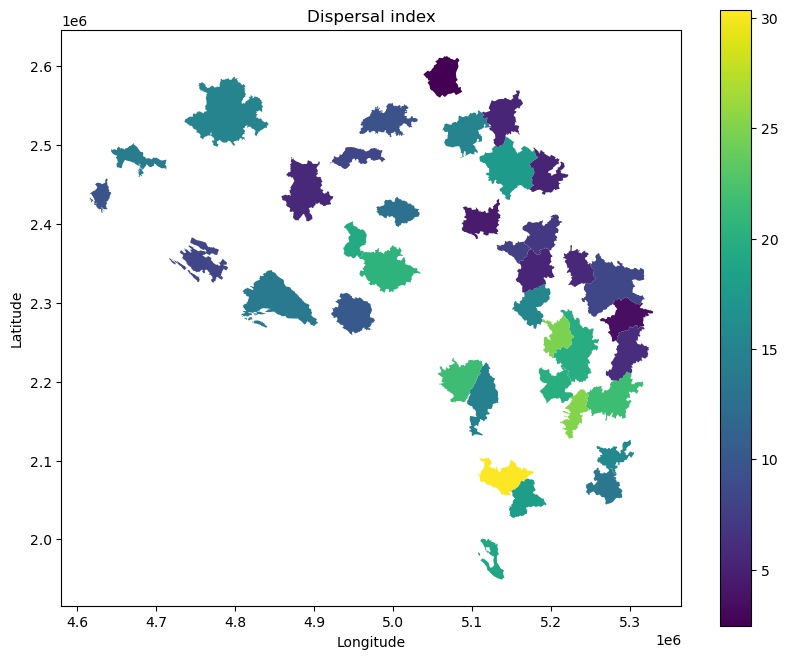

In [9]:
import matplotlib.pyplot as plt

# Plot the result column with FUA names
fuas.plot(column='dispersal_index', legend=True, figsize=(10, 8))
plt.title('Dispersal index')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [3]:
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
from shapely.geometry import mapping